# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [1]:
%load_ext autoreload
%autoreload 2

import cProfile as profile
import json
import numpy as np
import pandas as pd
import pprint
import time
import yaml

from benchmarks.generator import get_revenue_behaviour
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, TrainSchedulePlotter, infer_line_stations, get_services_by_tsp_df
from src.entities import GSA, Solution

from robin.kernel.entities import Kernel
from robin.plotter.entities import KernelPlotter
from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from tqdm.notebook import tqdm
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 100


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
AVLO                   16
IRYO                   40
AVE                    25
OUIGO                  19
Total                 100


Services:  100


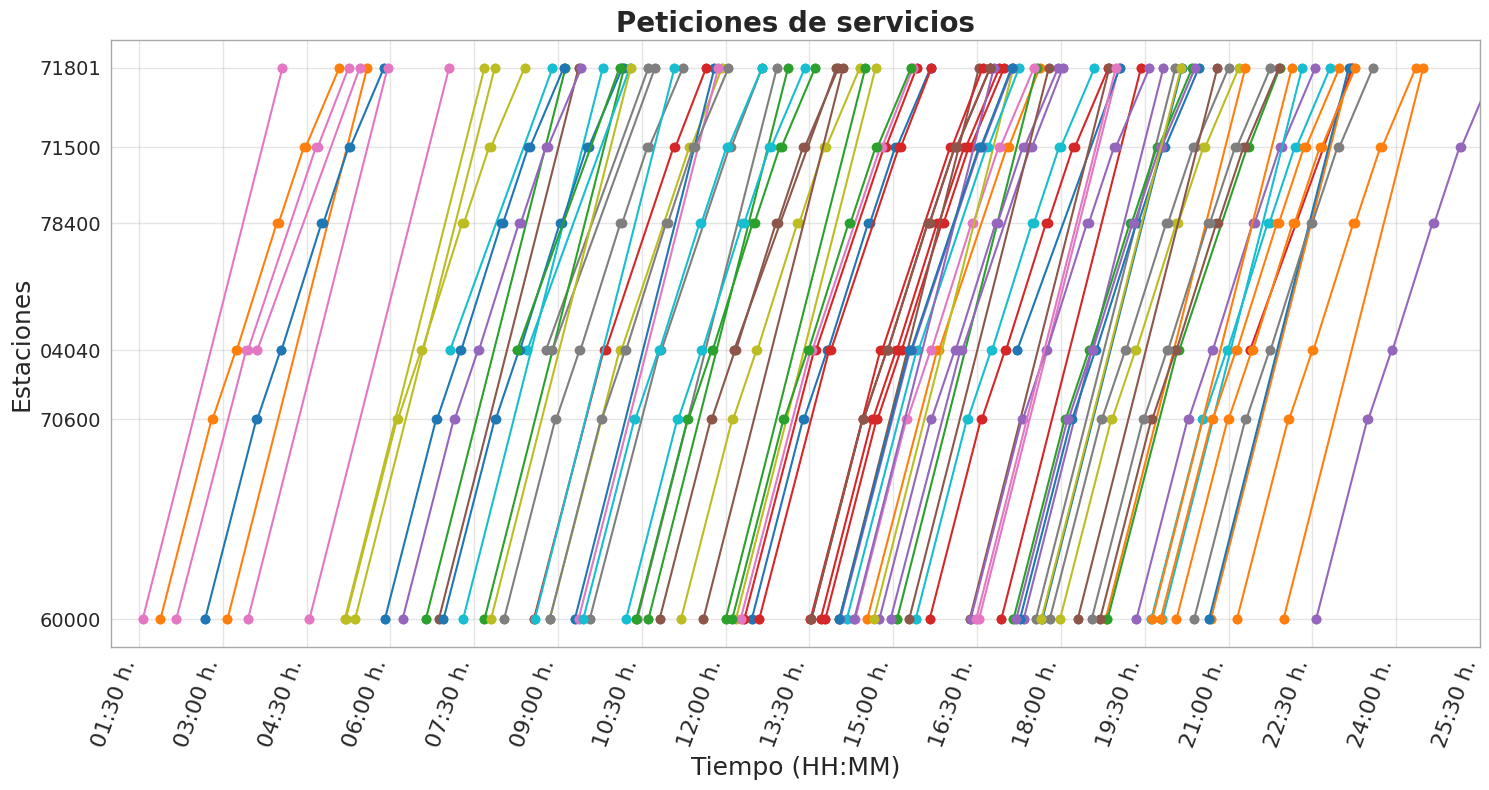

In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour(requested_schedule)
lines = supply.lines
line = infer_line_stations(lines)

plotter = TrainSchedulePlotter(requested_schedule, line)
plotter.plot(main_title="Peticiones de servicios")

In [6]:
#pr = profile.Profile()
#pr.enable()
import random

def run_gsa(chaotic_constant: bool=False,
            runs: int=10,
            population_size: int=20,
            iters: int=50,
            global_seed: int=21
            ) -> Tuple[pd.DataFrame, pd.DataFrame, Any]:
    random.seed(global_seed)
    
    runs_best_solution_history = {}
    
    global_train_hist = pd.DataFrame()
    global_population_hist = pd.DataFrame()
    
    for r in range(1, runs + 1):
        print(f"Run {r}")
        sm = RevenueMaximization(requested_schedule=requested_schedule,
                                 revenue_behaviour=revenue_behaviour,
                                 line=line,
                                 safe_headway=10)
    
        gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
                       is_feasible=sm.feasible_services_times,
                       custom_repair=sm.custom_repair,
                       r_dim=len(sm.boundaries.real),
                       d_dim=0,
                       boundaries=sm.boundaries)
        
        gsa_algo.set_seed(seed=random.randint(0, 1000))
        training_history = gsa_algo.optimize(population_size=population_size,
                                             iters=iters,
                                             chaotic_constant=chaotic_constant,
                                             repair_solution=True,
                                             initial_population=sm.get_initial_population(population),
                                             verbose=verbosity,
                                             save_population=True)
    
        training_history.insert(0, "Run", r)
        training_history['Discrete'] = [sm.get_heuristic_schedule(Solution(real=r, discrete=np.array([]))) for r in training_history['Real']]
        global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
        
        gsa_algo.population_history.insert(0, "Run", r)
        global_population_hist = pd.concat([global_population_hist, gsa_algo.population_history], axis=0)
    
        runs_best_solution_history[r] = (sm.best_solution, sm.best_revenue)
        
    return global_train_hist, global_population_hist, runs_best_solution_history
        
#pr.disable()
#pr.dump_stats('profile.pstat')

## 1. Chaotic vs Normal GSA

In [7]:
runs = 10
population = 20
iters = 100
verbosity = False
rbs_hist = {}

df_gcc = pd.DataFrame()
df_gpp = pd.DataFrame()
for chaotic_constant in [True, False]:
    print(f"Running GSA with chaotic constant: ", chaotic_constant)
    df_train, df_pop, rbs_hist[chaotic_constant] = run_gsa(chaotic_constant=chaotic_constant,
                                                           runs=runs,
                                                           population_size=population,
                                                           iters=iters)
    
    df_train["chaotic_constant"] = chaotic_constant
    df_gcc = pd.concat([df_gcc, df_train], axis=0)
    
    df_pop["chaotic_constant"] = chaotic_constant
    df_gpp = pd.concat([df_gpp, df_pop], axis=0)

Running GSA with chaotic constant:  True
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Running GSA with chaotic constant:  False
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10


## 2. Results analysis

In [8]:
# Define new revenue maximization object for results analysis
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

In [9]:
# Create dataframe with fitness values for each individual of the population
df_pop = df_gpp.copy()

df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

def fitness_from_real(x: np.array) -> float:
    solution_gsa = Solution(real=x, discrete=np.array([]))
    fitness, _ = sm.get_fitness_gsa(timetable=solution_gsa)
    return fitness

df_pop.loc[:, df_pop.columns.str.contains('real_')] = df_pop.loc[:, df_pop.columns.str.contains('real_')].map(fitness_from_real)
df_pop

,Run,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,real_7,...,real_11,real_12,real_13,real_14,real_15,real_16,real_17,real_18,real_19,chaotic_constant
0,1,0,8389.256874,8209.066435,8058.442856,8305.97479,8102.860707,7962.217044,8651.98648,8309.184079,...,8088.466883,8095.725951,7929.102345,8316.237369,8266.660105,8138.139182,8725.741948,8118.24921,8189.912896,True
1,1,1,8529.559163,8124.927184,8397.647299,8375.800539,8496.908267,8529.349324,8534.256774,8821.170903,...,8594.247892,8370.906697,8550.390834,8268.901388,8592.644896,8502.107713,8490.001023,8482.616779,8544.398789,True
2,1,2,8468.703061,8175.634253,8267.015069,8270.005011,8849.860144,8797.750567,8416.499153,8639.580862,...,8647.754425,8398.76104,8511.00878,8648.794176,8413.132816,8504.12291,8124.310557,8453.053525,8475.058259,True
3,1,3,8490.391715,8504.615591,8497.019735,8620.888976,8440.624257,8806.551928,8510.75389,8894.749789,...,8615.481236,8445.986926,8531.512062,8366.146473,8440.479781,8486.950451,8483.160667,8436.438184,8531.989792,True
4,1,4,8674.976597,8506.792767,8344.946691,8541.860123,8375.849103,8384.191094,8739.661722,8516.180914,...,8508.05946,8445.657053,8481.40263,8579.997899,8502.719584,8715.067682,8681.610959,8453.221233,8700.754187,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10,95,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,...,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,False
96,10,96,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,...,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,False
97,10,97,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,...,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,False
98,10,98,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,...,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,8851.995,False


In [10]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    chaotic = row[1]['chaotic_constant']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Chaotic': chaotic, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,Chaotic,Individual
0,1,0,8389.256874,True,ID_real_0
1,1,0,8209.066435,True,ID_real_1
2,1,0,8058.442856,True,ID_real_2
3,1,0,8305.974790,True,ID_real_3
4,1,0,8102.860707,True,ID_real_4
...,...,...,...,...,...
39995,10,99,8851.995000,False,ID_real_15
39996,10,99,8851.995000,False,ID_real_16
39997,10,99,8851.995000,False,ID_real_17
39998,10,99,8851.995000,False,ID_real_18


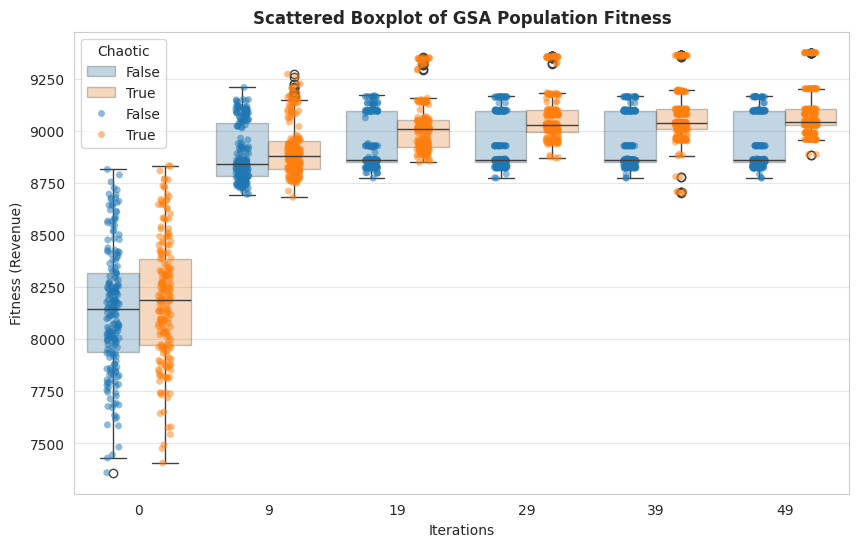

In [11]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 14, 29, 44, 59, 74, 99])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Chaotic',
             title="Scattered Boxplot of GSA Population Fitness",
             x_label="Iterations",
             y_label="Fitness (Revenue)",
             save_path=Path('../figures/scattered_boxplot.pdf'))

In [12]:
df_gcc

,Run,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real,chaotic_constant
0,1,0,8482.896597,0,0.925773,"[False, False, False, True, True, False, False...","[1066, 871, 955, 1033, 906, 833, 889, 915, 963...",True
1,1,1,8732.162461,0,3.329078,"[False, False, False, True, True, False, False...","[1057, 873, 952, 1031, 905, 823, 881, 911, 958...",True
2,1,2,8821.170903,0,5.766593,"[False, False, False, True, True, False, False...","[1061, 871, 954, 1032, 905, 828, 885, 913, 961...",True
3,1,3,8849.860144,0,8.185849,"[False, False, False, True, True, False, False...","[1063, 871, 951, 1029, 907, 829, 888, 914, 961...",True
4,1,4,8894.749789,0,10.614484,"[False, False, False, True, True, False, False...","[1061, 876, 953, 1030, 905, 828, 885, 914, 960...",True
...,...,...,...,...,...,...,...,...
95,10,95,9081.886927,0,208.036872,"[False, False, False, False, True, False, Fals...","[1057, 868, 947, 1027, 900, 828, 885, 912, 960...",False
96,10,96,9081.886927,0,210.172437,"[False, False, False, False, True, False, Fals...","[1057, 868, 947, 1027, 900, 828, 885, 912, 960...",False
97,10,97,9081.886927,0,212.318493,"[False, False, False, False, True, False, Fals...","[1057, 868, 947, 1027, 900, 828, 885, 912, 960...",False
98,10,98,9081.886927,0,214.509649,"[False, False, False, False, True, False, Fals...","[1057, 868, 947, 1027, 900, 828, 885, 912, 960...",False


In [36]:
# Table with results by run
service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == True]
run_grouped_df = df_train_chaotic.groupby('Run')

for group in run_grouped_df.groups:
    run = run_grouped_df.get_group(group)['Run'].iloc[-1]
    revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
    execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
    scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
    scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
    real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
    sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
    delta_dt = 0.0
    delta_tt = 0.0
    services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
    for i, service in enumerate(sm.requested_schedule):
        if not scheduled_trains_array[i]:
            continue
        departure_station = list(sm.requested_schedule[service].keys())[0]
        delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                        sm.requested_schedule[service][departure_station][1])
        for j, stop in enumerate(sm.requested_schedule[service].keys()):
            if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                continue
            delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])

        service_tsp = service_tsps[service]
        services_by_tsp[service_tsp] += 1

    percentages_by_tsp = {}
    for tsp in services_by_tsp:
        percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
    row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
    summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),IRYO,AVLO,OUIGO,AVE
2,3,9373.952663,216.539771,29,29.0,539.0,62.5 %,20.0 %,28.0 %,21.05 %
8,9,9273.450239,216.740637,30,56.0,612.0,50.0 %,27.5 %,24.0 %,26.32 %
7,8,9104.383592,216.391855,29,35.0,553.0,56.25 %,25.0 %,20.0 %,26.32 %
4,5,9091.308973,218.548997,29,50.0,523.0,68.75 %,20.0 %,24.0 %,21.05 %
6,7,9083.505007,216.512543,30,44.0,555.0,56.25 %,30.0 %,20.0 %,21.05 %
1,2,9055.015966,217.842502,29,58.0,562.0,62.5 %,22.5 %,20.0 %,26.32 %
5,6,9049.162529,218.680905,29,41.0,466.0,50.0 %,27.5 %,20.0 %,26.32 %
9,10,9030.072198,217.446863,29,34.0,570.0,56.25 %,25.0 %,20.0 %,26.32 %
0,1,9026.542911,219.595570,28,41.0,547.0,68.75 %,20.0 %,20.0 %,21.05 %
3,4,8972.559032,217.384584,28,55.0,588.0,62.5 %,20.0 %,24.0 %,21.05 %


In [38]:
# Table with results by run
service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df_normal = pd.DataFrame(columns=columns)

df_train_gsa = df_gcc[df_gcc['chaotic_constant'] == False]
run_grouped_df_normal = df_train_gsa.groupby('Run')

for group in run_grouped_df_normal.groups:
    run = run_grouped_df_normal.get_group(group)['Run'].iloc[-1]
    revenue = run_grouped_df_normal.get_group(group)['Fitness'].iloc[-1]
    execution_time = run_grouped_df_normal.get_group(group)['ExecutionTime'].iloc[-1]
    scheduled_trains_array = run_grouped_df_normal.get_group(group)['Discrete'].iloc[-1]
    scheduled_trains = int(sum(run_grouped_df_normal.get_group(group)['Discrete'].iloc[-1]))
    real_solution = run_grouped_df_normal.get_group(group)['Real'].iloc[-1]
    sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
    delta_dt = 0.0
    delta_tt = 0.0
    services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
    for i, service in enumerate(sm.requested_schedule):
        if not scheduled_trains_array[i]:
            continue
        departure_station = list(sm.requested_schedule[service].keys())[0]
        delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                        sm.requested_schedule[service][departure_station][1])
        for j, stop in enumerate(sm.requested_schedule[service].keys()):
            if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                continue
            delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])

        service_tsp = service_tsps[service]
        services_by_tsp[service_tsp] += 1

    percentages_by_tsp = {}
    for tsp in services_by_tsp:
        percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
    row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
    summary_df_normal.loc[len(summary_df)] = row_data

summary_df_normal = summary_df_normal.sort_values('Revenue', ascending=False)
display(summary_df_normal)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),IRYO,AVLO,OUIGO,AVE
10,10,9081.886927,216.626435,29,58.0,577.0,50.0 %,27.5 %,20.0 %,26.32 %


In [14]:
# Global status
print("Global GSA status:")

# Execution time (mean and std.)
run_times = run_grouped_df['ExecutionTime'].last()
print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')

# Revenue (mean and std.)
run_revenues = run_grouped_df['Fitness'].last()
print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')

# Scheduled trains (mean and std.)
run_trains = run_grouped_df['Discrete'].last().apply(sum)
print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')

runs_best_solution_history = dict(sorted(rbs_hist[True].items(),
                                         key=lambda x: x[1][1]))

q2_solution_index = np.floor(runs // 2).astype(int)
gsa_solution = tuple(runs_best_solution_history.items())[q2_solution_index]

print(f"\tMedian solution: Run {gsa_solution[0]}")
max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")

Global GSA status:
	Total execution time: 2175.6842 s.
	Execution Time (by run) - Mean: 217.5684 s. - Std: 1.0891 s.
	Revenue - Mean: 9105.9953 - Std: 123.0526
	Scheduled Trains - Mean: 29.0 - Std: 1.0
	Median solution: Run 7
	Max Revenue: 25729.0 - WARNING!: Scheduling all services could not be feasible


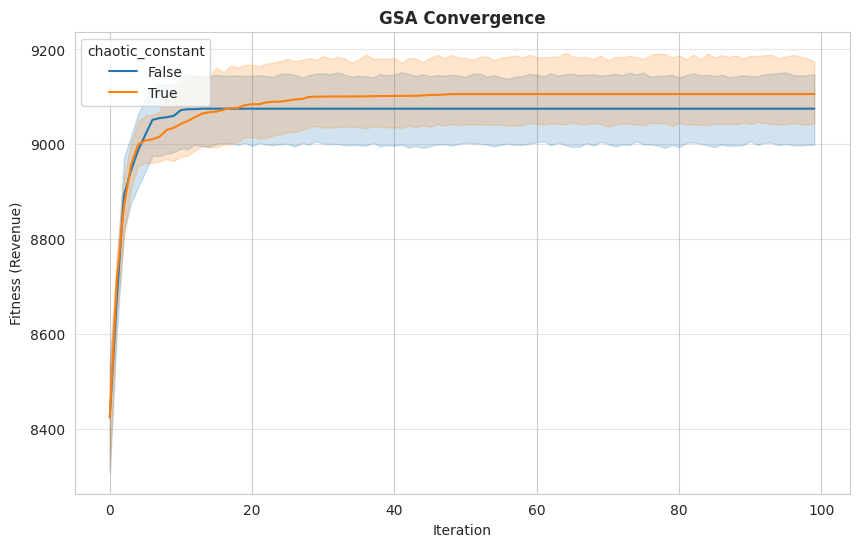

In [15]:
# GSA Convergence plot
sns_line_plot(df=df_gcc,
              x_data="Iteration",
              y_data="Fitness",
              hue="chaotic_constant",
              title="GSA Convergence",
              x_label="Iteration",
              y_label="Fitness (Revenue)",
              save_path=Path('../figures/gsa_convergence.pdf'))

/home/oreto2024/PycharmProjects/GSA_M/venv/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


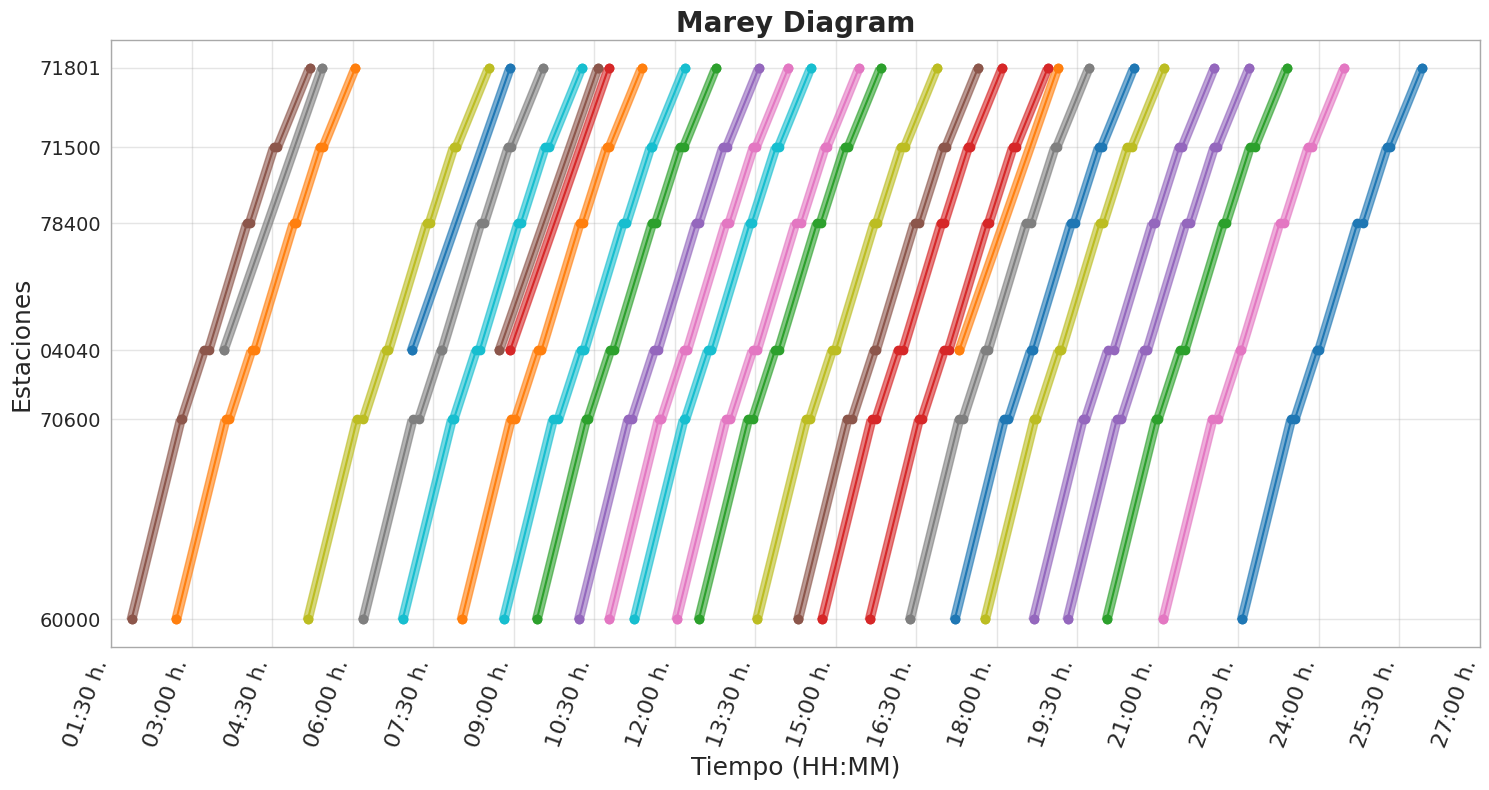

In [16]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=gsa_solution[1][0])

sm.update_schedule(solution=gsa_solution[1][0])

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if gsa_solution[1][0].discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

plotter = TrainSchedulePlotter(filtered_services, line)
plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)
supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

In [17]:
#!snakeviz profile.pstat

In [18]:
# Simulate market
kernel = Kernel(path_config_supply=supply_config_file,
                path_config_demand=demand_config_path,
                seed=21)

services = kernel.simulate(output_path=Path(f'{robin_save_path}output.csv'),
                           save_trace=True,
                           departure_time_hard_restriction=True)

kernel_plotter = KernelPlotter(path_output_csv=Path(f'{robin_save_path}output.csv'),
                               path_config_supply=supply_config_file)

kernel_plotter.plotter_data_analysis()

Data from demand plot: 
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 4809
	Status: User bought a service which was not the one with the best utility. - Passengers: 2575
	Status: User bought the ticket with best utility. - Passengers: 1548
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  4123
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 651 - Percentage: 15.79 %
		Seat: Turista - Passengers: 2902 - Percentage: 70.39 %
		Seat: TuristaPlus - Passengers: 570 - Percentage: 13.82 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  4123
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Turista - Number of tickets sold: 220
			Seat: TuristaPlus - Number of tickets sold: 262
		Date: 2023-06-12
			Seat: Turista - Number of tickets sold: 203
			Seat: TuristaPlus - Number of tickets sold: 133
		Date: 2023-06-13
			S

{'Tourist': {'TuristaPlus': 261, 'Turista': 1865}, 'EventTourist': {'Turista': 562, 'TuristaPlus': 138, 'Premium': 8}, 'Adventurer': {'TuristaPlus': 171, 'Premium': 185, 'Turista': 54}, 'Business': {'Premium': 443, 'Turista': 168}, 'Student': {'Turista': 253, 'Premium': 15}}


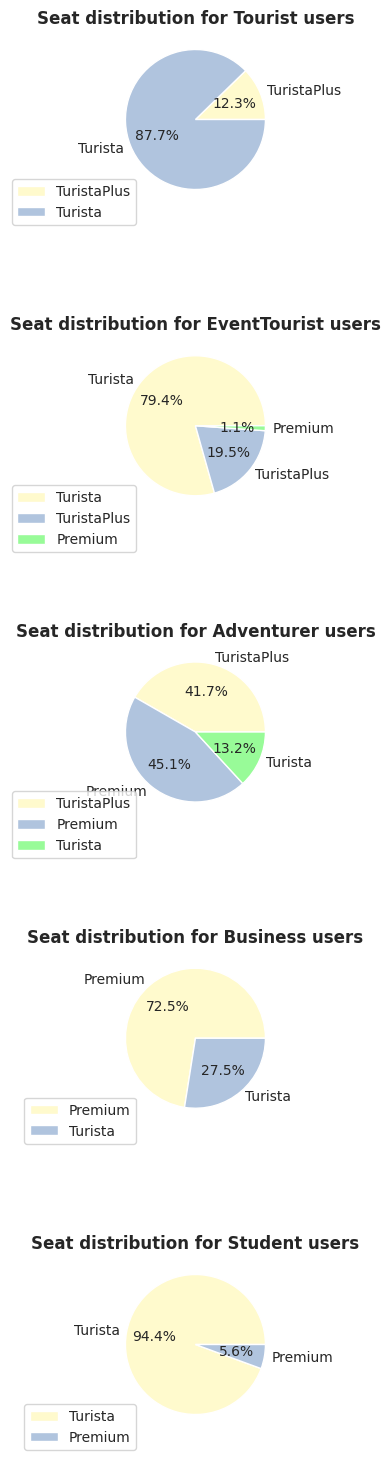

In [19]:
kernel_plotter.plot_users_seat_pie_chart(save_path='../figures/users_seat_pie_chart.pdf')

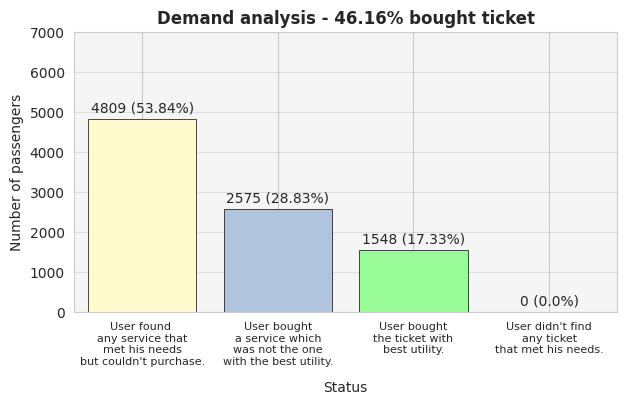

In [20]:
kernel_plotter.plot_demand_status(y_limit=7000)

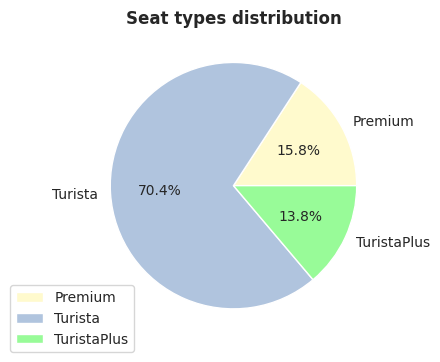

In [21]:
kernel_plotter.plot_seat_distribution_pie_chart()

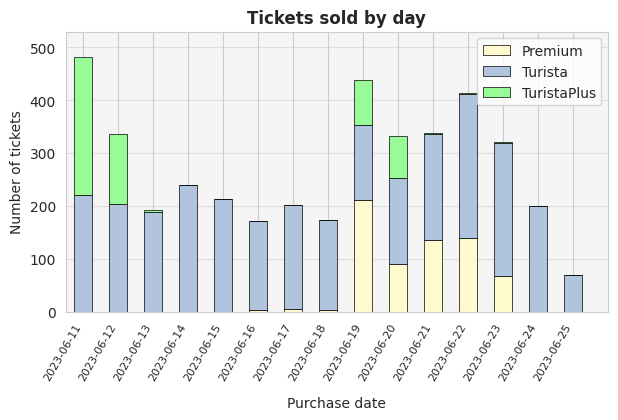

In [22]:
kernel_plotter.plot_tickets_by_date()

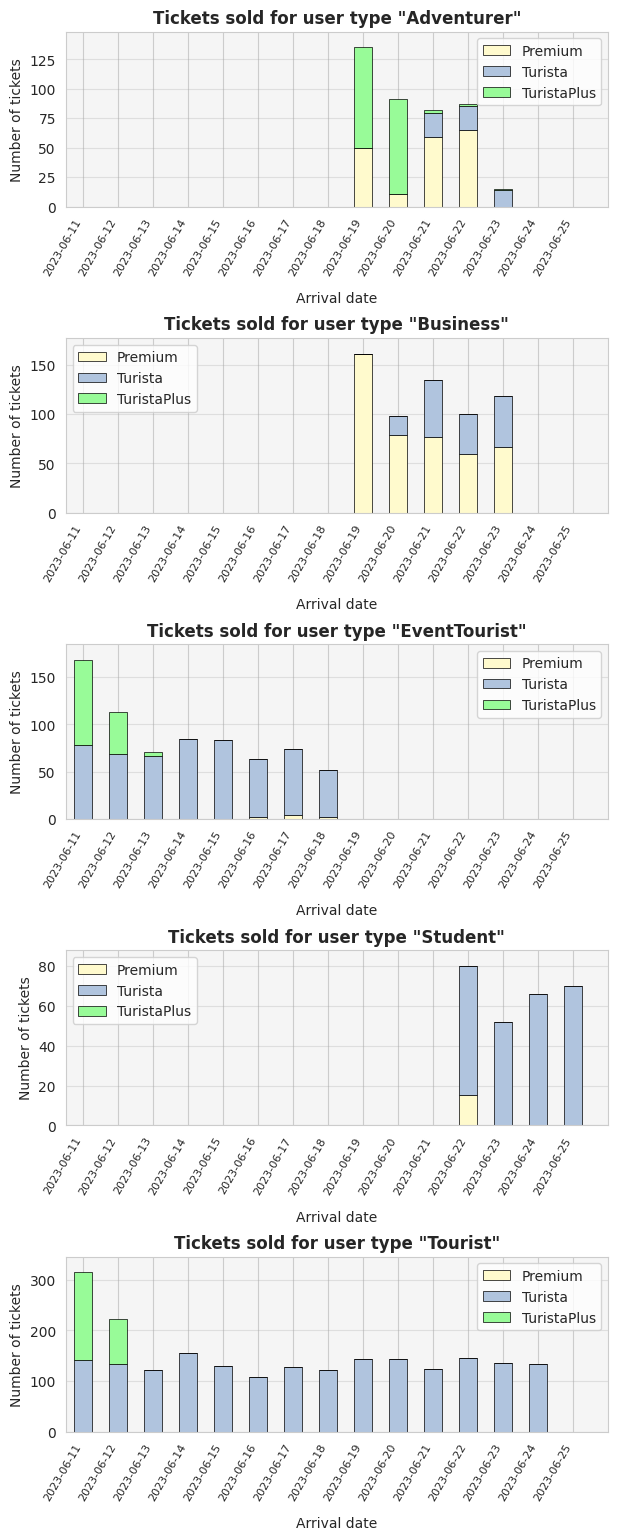

In [23]:
kernel_plotter.plot_tickets_by_user()

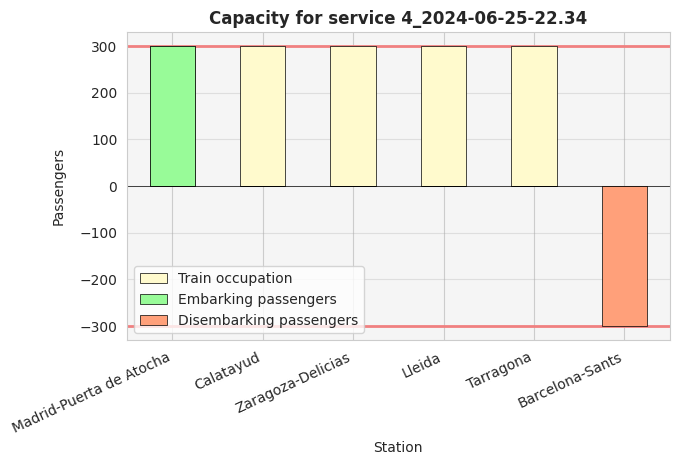

In [24]:
kernel_plotter.plot_service_capacity(service_id='4_2024-06-25-22.34')

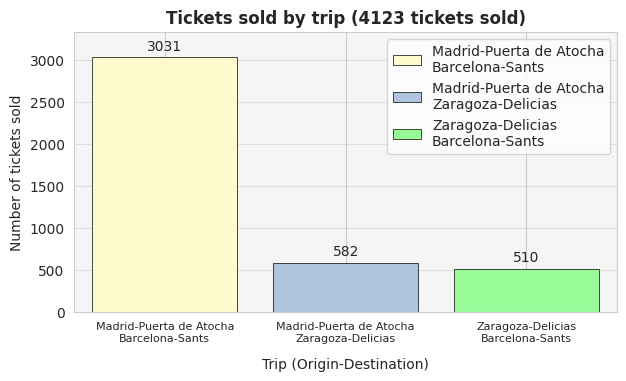

In [25]:
kernel_plotter.plot_tickets_by_pair()

## Load inference trace

In [26]:
trace_path = Path(f'{robin_save_path}/inference_trace.json')

# Load trace json
with open(trace_path, 'r') as f:
    trace = json.load(f)

In [27]:
# Tickets bought by user pattern

n_pass = {}
for t in trace:
   if trace[t]['user_pattern'] not in n_pass:
       n_pass[trace[t]['user_pattern']] = 1
   else:
       n_pass[trace[t]['user_pattern']] += 1

n_pass

{'Tourist': 2126,
 'EventTourist': 708,
 'Adventurer': 410,
 'Business': 611,
 'Student': 268}

## Load user patterns and variables from demand config file

In [28]:
# Load demand config yaml
with open(demand_config_path, 'r') as f:
    demand_config = yaml.safe_load(f)

In [29]:
user_patterns = []
variables = {}
rules = {}

for user_pattern in demand_config['userPattern']:
    user_patterns.append(user_pattern['name'])
    for variable in user_pattern['variables']:
        if variable['name'] not in variables:
            if variable['type'] == 'fuzzy':
                variables[variable['name']] = variable['sets']
            elif variable['type'] == 'categorical':
                variables[variable['name']] = variable['labels']
        else:
            # Assert set matches
            if variable['type'] == 'fuzzy':
                assert variables[variable['name']] == variable['sets']
            elif variable['type'] == 'categorical':
                assert variables[variable['name']] == variable['labels']
                
    rules[user_pattern['name']] = [rule for rule in user_pattern['rules']]
                
print(user_patterns)
pprint.pp(variables)
pprint.pp(rules)

['Business', 'Student', 'Tourist', 'EventTourist', 'Adventurer']
{'origin': ['very_near', 'mid_range', 'far', 'far_away'],
 'destination': ['very_near', 'mid_range', 'far', 'far_away'],
 'departure_time': ['in_time', 'close', 'remote', 'very_remote'],
 'arrival_time': ['in_time', 'close', 'remote', 'very_remote'],
 'price': ['very_cheap', 'cheap', 'medium', 'expensive'],
 'seat': ['Turista', 'TuristaPlus', 'Premium'],
 'tsp': ['AVE', 'AVLO', 'OUIGO', 'IRYO']}
{'Business': ['R0', 'R1', 'R2'],
 'Student': ['R0', 'R1', 'R2', 'R3'],
 'Tourist': ['R0', 'R1', 'R2', 'R3'],
 'EventTourist': ['R0', 'R1', 'R2'],
 'Adventurer': ['R0', 'R1', 'R2']}


In [30]:
# Create dataframes for each behaviour variable

behaviour_dfs = {}
for variable in variables:
    behaviour_dfs[variable] = pd.DataFrame(columns=user_patterns, index=variables[variable])
    
    for variable_set in variables[variable]:
        behaviour_dfs[variable].loc[variable_set] = [np.zeros(3) for _ in range(len(user_patterns))]
        
    print(behaviour_dfs[variable])

                  Business          Student          Tourist     EventTourist  \
very_near  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   
mid_range  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   
far        [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   
far_away   [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   

                Adventurer  
very_near  [0.0, 0.0, 0.0]  
mid_range  [0.0, 0.0, 0.0]  
far        [0.0, 0.0, 0.0]  
far_away   [0.0, 0.0, 0.0]  
                  Business          Student          Tourist     EventTourist  \
very_near  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   
mid_range  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   
far        [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   
far_away   [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   

                Adventurer  
very_near  [0.

In [31]:
def update_behaviour_dfs(behaviour_dfs: Mapping[str, pd.DataFrame],
                         user_pattern: str,
                         rules: List):
    passenger_set = set()
    def recurse_elements(element):
        if isinstance(element, dict):
            if 'variable' in element:
                if element['variable'] in behaviour_dfs:
                    set_name_and_values = element['setname_and_values']
                    set_name = set_name_and_values[0] if type(set_name_and_values) is list else set_name_and_values
                    if set_name in behaviour_dfs[element['variable']].index:
                        behaviour_dfs[element['variable']].loc[set_name, user_pattern][0] += element['result']
                        behaviour_dfs[element['variable']].loc[set_name, user_pattern][1] += 1
                        if (element['variable'], set_name) not in passenger_set:
                            behaviour_dfs[element['variable']].loc[set_name, user_pattern][2] += 1
                            passenger_set.add((element['variable'], set_name))
            for value in element.values():
                recurse_elements(value)
        elif isinstance(element, list):
            for item in element:
                recurse_elements(item)

    for rule in rules:
        recurse_elements(rule)

    return behaviour_dfs

for passenger in trace:
    user_pattern = trace[passenger]['user_pattern']
    behaviour_dfs = update_behaviour_dfs(behaviour_dfs=behaviour_dfs,
                                         user_pattern=user_pattern,
                                         rules=trace[passenger]['trace_of_each_rule'])

In [32]:
# Multicolumn pandas dataframes

for df in behaviour_dfs: 
    values = behaviour_dfs[df].values
    np_vals = np.array([val for row in values for data in row for val in data], dtype=np.float32)
    np_vals = np_vals.reshape(len(behaviour_dfs[df].index), 3 * len(user_patterns))
    
    midx = pd.MultiIndex.from_product([user_patterns, ['Sum', 'Count', 'Passengers']])
    multicol_df = pd.DataFrame(np_vals, index=behaviour_dfs[df].index, columns=midx)
    display(multicol_df)

Business                   Student                   Tourist  \
               Sum  Count Passengers     Sum  Count Passengers     Sum   
very_near    611.0  611.0      611.0   536.0  536.0      268.0  2126.0   
mid_range      0.0    0.0        0.0     0.0    0.0        0.0     0.0   
far            0.0    0.0        0.0     0.0    0.0        0.0     0.0   
far_away       0.0    0.0        0.0     0.0    0.0        0.0     0.0   

                             EventTourist                   Adventurer         \
            Count Passengers          Sum  Count Passengers        Sum  Count   
very_near  2126.0     2126.0        708.0  708.0      708.0      410.0  410.0   
mid_range  2126.0     2126.0          0.0    0.0        0.0        0.0  410.0   
far           0.0        0.0          0.0    0.0        0.0        0.0    0.0   
far_away      0.0        0.0          0.0    0.0        0.0        0.0    0.0   

                      
          Passengers  
very_near      410.0  
mid_range      410.0  
far              0.0  
far_away         0.0

Business                   Student                   Tourist  \
               Sum  Count Passengers     Sum  Count Passengers     Sum   
very_near    611.0  611.0      611.0   536.0  536.0      268.0  2126.0   
mid_range      0.0    0.0        0.0     0.0    0.0        0.0     0.0   
far            0.0    0.0        0.0     0.0    0.0        0.0     0.0   
far_away       0.0    0.0        0.0     0.0    0.0        0.0     0.0   

                             EventTourist                   Adventurer        \
            Count Passengers          Sum  Count Passengers        Sum Count   
very_near  2126.0     2126.0        708.0  708.0      708.0        0.0   0.0   
mid_range     0.0        0.0          0.0    0.0        0.0        0.0   0.0   
far           0.0        0.0          0.0    0.0        0.0        0.0   0.0   
far_away      0.0        0.0          0.0    0.0        0.0        0.0   0.0   

                      
          Passengers  
very_near        0.0  
mid_range        0.0  
far              0.0  
far_away         0.0

Business                     Student                   Tourist  \
                 Sum  Count Passengers       Sum  Count Passengers     Sum   
in_time        611.0  611.0      611.0  261.8125  268.0      268.0     0.0   
close            0.0    0.0        0.0    0.0000    0.0        0.0     0.0   
remote           0.0    0.0        0.0    0.0000    0.0        0.0     0.0   
very_remote      0.0    0.0        0.0    0.0000    0.0        0.0     0.0   

                             EventTourist                   Adventurer        \
            Count Passengers          Sum  Count Passengers        Sum Count   
in_time       0.0        0.0        708.0  708.0      708.0        0.0   0.0   
close         0.0        0.0          0.0    0.0        0.0        0.0   0.0   
remote        0.0        0.0          0.0    0.0        0.0        0.0   0.0   
very_remote   0.0        0.0          0.0    0.0        0.0        0.0   0.0   

                        
            Passengers  
in_time            0.0  
close              0.0  
remote             0.0  
very_remote        0.0

Business                       Student                    \
                    Sum  Count Passengers         Sum  Count Passengers   
in_time      602.960022  611.0      611.0  259.287506  268.0      268.0   
close          0.000000    0.0        0.0    0.000000    0.0        0.0   
remote         0.000000    0.0        0.0    0.000000    0.0        0.0   
very_remote    0.000000    0.0        0.0    0.000000    0.0        0.0   

            Tourist                  EventTourist                    \
                Sum Count Passengers          Sum  Count Passengers   
in_time         0.0   0.0        0.0   672.390015  708.0      708.0   
close           0.0   0.0        0.0     0.000000    0.0        0.0   
remote          0.0   0.0        0.0     0.000000    0.0        0.0   
very_remote     0.0   0.0        0.0     0.000000    0.0        0.0   

            Adventurer                   
                   Sum Count Passengers  
in_time            0.0   0.0        0.0  
close              0.0   0.0        0.0  
remote             0.0   0.0        0.0  
very_remote        0.0   0.0        0.0

Business                      Student                   Tourist  \
                Sum Count Passengers         Sum  Count Passengers     Sum   
very_cheap      0.0   0.0        0.0    0.000000  536.0      268.0     0.0   
cheap           0.0   0.0        0.0  526.789978  536.0      268.0  1670.0   
medium          0.0   0.0        0.0    0.000000    0.0        0.0     0.0   
expensive       0.0   0.0        0.0    0.000000    0.0        0.0     0.0   

                              EventTourist                    Adventurer  \
             Count Passengers          Sum  Count Passengers         Sum   
very_cheap  1670.0     1670.0     0.000000  708.0      708.0    4.557000   
cheap       1670.0     1670.0    60.512001  708.0      708.0  362.290009   
medium         0.0        0.0   646.223999  708.0      708.0    0.000000   
expensive      0.0        0.0     0.000000    0.0        0.0    0.000000   

                              
            Count Passengers  
very_cheap  409.0      409.0  
cheap       409.0      409.0  
medium        0.0        0.0  
expensive     0.0        0.0

Business                   Student                  Tourist  \
                 Sum  Count Passengers     Sum Count Passengers     Sum   
Turista          0.0    0.0        0.0     0.0   0.0        0.0  6378.0   
TuristaPlus      0.0    0.0        0.0     0.0   0.0        0.0     0.0   
Premium        443.0  443.0      443.0     0.0   0.0        0.0     0.0   

                               EventTourist                  Adventurer  \
              Count Passengers          Sum Count Passengers        Sum   
Turista      6378.0     2126.0          0.0   0.0        0.0        0.0   
TuristaPlus  6378.0     2126.0          0.0   0.0        0.0      221.0   
Premium         0.0        0.0          0.0   0.0        0.0        0.0   

                               
             Count Passengers  
Turista        0.0        0.0  
TuristaPlus  221.0      221.0  
Premium        0.0        0.0

Business                   Student                  Tourist          \
           Sum  Count Passengers     Sum Count Passengers     Sum   Count   
AVE      401.0  409.0      409.0     0.0   0.0        0.0     0.0     0.0   
AVLO       8.0  409.0      409.0     0.0   0.0        0.0   456.0  2126.0   
OUIGO      0.0    0.0        0.0     0.0   0.0        0.0  1247.0  2126.0   
IRYO       0.0    0.0        0.0     0.0   0.0        0.0   423.0  2126.0   

                 EventTourist                  Adventurer                   
      Passengers          Sum Count Passengers        Sum Count Passengers  
AVE          0.0          0.0   0.0        0.0        0.0   0.0        0.0  
AVLO      2126.0          0.0   0.0        0.0        0.0   0.0        0.0  
OUIGO     2126.0          0.0   0.0        0.0        0.0   0.0        0.0  
IRYO      2126.0          0.0   0.0        0.0        0.0   0.0        0.0

In [33]:
rules_dfs = {}
columns = ['Consequent', 'Percentage']
for user_type in rules:
    rules_dfs[user_type] = pd.DataFrame(columns=rules[user_type], index=np.array(columns))
    
    # Fill dataframe with zeros
    for rule in rules[user_type]:
        for col in columns:
            rules_dfs[user_type].loc[col, rule] = np.float32(0.0)
    
    print(rules_dfs[user_type])

             R0   R1   R2
Consequent  0.0  0.0  0.0
Percentage  0.0  0.0  0.0
             R0   R1   R2   R3
Consequent  0.0  0.0  0.0  0.0
Percentage  0.0  0.0  0.0  0.0
             R0   R1   R2   R3
Consequent  0.0  0.0  0.0  0.0
Percentage  0.0  0.0  0.0  0.0
             R0   R1   R2
Consequent  0.0  0.0  0.0
Percentage  0.0  0.0  0.0
             R0   R1   R2
Consequent  0.0  0.0  0.0
Percentage  0.0  0.0  0.0


In [34]:
def update_rules_dfs(rules_dfs: Mapping[str, pd.DataFrame],
                     user_pattern: str,
                     rules: List):
   
    for rule in rules:
        rules_dfs[user_pattern].loc['Consequent', rule['name']] += rule['result']

    return rules_dfs

for passenger in trace:
    user_pattern = trace[passenger]['user_pattern']
    behaviour_dfs = update_rules_dfs(rules_dfs=rules_dfs,
                                     user_pattern=user_pattern,
                                     rules=trace[passenger]['trace_of_each_rule'])
    
# Round cells of dataframe to 2 decimals
for user_type in rules_dfs:
    rules_dfs[user_type] = rules_dfs[user_type].round(2)
    
    # Sum of values in 'Consequent' row
    sum_consequents = 0.0
    for col in rules_dfs[user_type].columns:
        sum_consequents += rules_dfs[user_type].loc['Consequent', col]
        
    # Update 'Percentage' row
    for col in rules_dfs[user_type].columns:
        rules_dfs[user_type].loc['Percentage', col] = f"{np.round(rules_dfs[user_type].loc['Consequent', col] / sum_consequents * 100, 2)} %"

for user_type in rules_dfs:
    print(f'User: {user_type}')
    display(rules_dfs[user_type])

User: Business


,R0,R1,R2
Consequent,9106.24,8382.34,36285.1582
Percentage,16.93 %,15.59 %,67.48 %


User: Student


,R0,R1,R2,R3
Consequent,2716.7,5298.81381,2608.504733,15718.83927
Percentage,10.31 %,20.11 %,9.9 %,59.67 %


User: Tourist


,R0,R1,R2,R3
Consequent,33544.22,21341.76,42434.34,106219.8
Percentage,16.48 %,10.49 %,20.85 %,52.19 %


User: EventTourist


,R0,R1,R2
Consequent,17639.02416,33601.5315,17750.19
Percentage,25.57 %,48.7 %,25.73 %


User: Adventurer


,R0,R1,R2
Consequent,20190.43607,14350.89,2228.13
Percentage,54.91 %,39.03 %,6.06 %
